In [84]:
import sys
sys.path.append('../')

import gc
import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats

#from sa_decomp_layer import SADecompLayer



import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


#tf.__version__
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16, ResNet152, ResNet50

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp
from glob import glob


from tensorflow.keras.utils import to_categorical
from tensorflow.data import Dataset, AUTOTUNE
from imagenet_utils.imagenet_clsloc2 import clsloc
from imagenet_utils.load_images import load_images
from imagenet_utils.preprocess import preprocess

from utils.utils import *

import keras
from keras import layers

from keras import backend as K

import scienceplots

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '600'})

(128, 128)


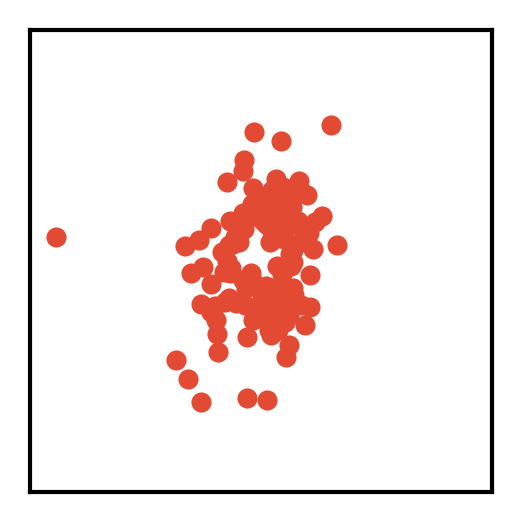

In [85]:
gc.collect()


model = ResNet50(weights='imagenet',
				  include_top=True,
				  input_shape=(224, 224, 3))

model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=False),            
			metrics=[
				keras.metrics.CategoricalAccuracy(name="accuracy"),
				keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),])

F = 7
fig, ax = plt.subplots(1,1,figsize = (1,1))

filters = get_filter(model,5)  #[:,:,:, top10F.indices.numpy()]
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
dc = np.sign(np.mean(filters, axis=(0,1)))
#idx = tf.where(tf.less(dc[:, F],0))[:,0].numpy()
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])
mag = reduce_euclidean_norm(filters, axis=[0,1])
print(mag.shape)
x =a_mag[:,F]*np.cos((theta[:,F]))
y = a_mag[:,F]*np.sin((theta[:,F]))
lim_x = np.max(np.abs(x))
lim_y = np.max(np.abs(y))
lim = np.max([lim_x, lim_y])
lim =np.max(np.abs(mag[:, F]))    
lim*= 1

ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.scatter(x,y, s=2, color='#E24A33')
ax.set_box_aspect(1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
ax.collections[0].set_rasterized(True)

plt.show()


In [86]:
conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		if l.kernel_size == (3,3) or l.kernel_size == (7,7):
			conv_layers.append(l)
			print(l)

In [87]:
def rotate (model_original, layers)  :
	model = tf.keras.models.clone_model(model_original)
	model.set_weights(model_original.get_weights())
	conv_layers = []
	for l in model.layers:
		if 'conv2d' in str(type(l)).lower():
			if l.kernel_size == (3,3) or l.kernel_size == (7,7):
				conv_layers.append(l)
				print(l)
	for l in layers:
		filters, biases = conv_layers[l].get_weights()
		print(conv_layers[l].name)
		# Reshape weights to (64 * 128, 3, 3) for batch processing
		k = filters.shape[0]
		weights_reshaped = tf.reshape(filters, (k, k,-1))

		rotated_weights = tf.image.rot90(weights_reshaped, k=2)
		rotated_weights = tf.reshape(rotated_weights, (k, k,filters.shape[-2],filters.shape[-1]))
		
		conv_layers[l].set_weights([rotated_weights, biases])


	return model

		




In [88]:
# Imagenet Validation Set location
img = "C:/ILSVRC2012_img_val/ILSVRC2012_val_00000028.JPEG"

In [89]:
train_list = glob("C:/imagenette2/train/*/*.JPEG")
train_labels = glob("C:/imagenette2/train/*/*.JPEG")
train_labels = to_categorical([clsloc[os.path.normpath(str(path)).split(os.path.sep)[-2]] for path in train_labels], num_classes = 1000)


trainDS = Dataset.from_tensor_slices((train_list, train_labels))
trainDS = (trainDS
	.map(load_images)
	.map(preprocess)
	.cache()
	.batch(1)
	.prefetch(AUTOTUNE)
)


val_list = glob("C:/imagenette2/val/*/*.JPEG")
val_labels = glob("C:/imagenette2/val/*/*.JPEG")
val_labels = to_categorical([clsloc[os.path.normpath(str(path)).split(os.path.sep)[-2]] for path in val_list], num_classes = 1000)


valDS = Dataset.from_tensor_slices((val_list, val_labels))
valDS = (valDS
	.map(load_images)
	.map(preprocess)
	.cache()
	.batch(32)
	.prefetch(AUTOTUNE)
)

In [90]:
val_labels.shape

(3925, 1000)

In [91]:
model_rot = rotate(model, list(range(len(conv_layers))))
model_rot.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=False),            
			metrics=[
				keras.metrics.CategoricalAccuracy(name="accuracy"),
				keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),])

conv1_conv
conv2_block1_2_conv
conv2_block2_2_conv
conv2_block3_2_conv
conv3_block1_2_conv
conv3_block2_2_conv
conv3_block3_2_conv
conv3_block4_2_conv
conv4_block1_2_conv
conv4_block2_2_conv
conv4_block3_2_conv
conv4_block4_2_conv
conv4_block5_2_conv
conv4_block6_2_conv
conv5_block1_2_conv
conv5_block2_2_conv
conv5_block3_2_conv


(128, 128)


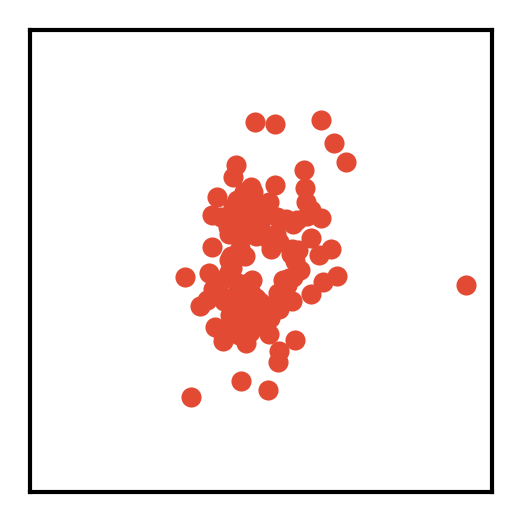

In [92]:

F = 7
fig, ax = plt.subplots(1,1,figsize = (1,1))

filters = get_filter(model_rot,5)  #[:,:,:, top10F.indices.numpy()]
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
dc = np.sign(np.mean(filters, axis=(0,1)))
#idx = tf.where(tf.less(dc[:, F],0))[:,0].numpy()
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])
mag = reduce_euclidean_norm(filters, axis=[0,1])
print(mag.shape)
x =a_mag[:,F]*np.cos((theta[:,F]))
y = a_mag[:,F]*np.sin((theta[:,F]))
lim_x = np.max(np.abs(x))
lim_y = np.max(np.abs(y))
lim = np.max([lim_x, lim_y])
lim =np.max(np.abs(mag[:, F]))    
lim*= 1

ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.scatter(x,y, s=2, color='#E24A33')
ax.set_box_aspect(1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
ax.collections[0].set_rasterized(True)

plt.show()


In [93]:
model_rot.evaluate(valDS)

123/123 [==============================] - 26s 190ms/step - loss: 2.3469 - accuracy: 0.4973 - top-5-accuracy: 0.7167


[2.346891403198242, 0.4973248541355133, 0.7166879177093506]

In [94]:
model.evaluate(valDS)

123/123 [==============================] - 13s 95ms/step - loss: 0.3787 - accuracy: 0.8917 - top-5-accuracy: 0.9834


[0.3786778450012207, 0.8917197585105896, 0.9834395051002502]